In [4]:
# Import necessary libraries and modules
import pandas as pd
import john_prepare as p
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Set the option to display all columns in DataFrames
pd.set_option('display.max_columns', None)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
inspection_df = p.prepare_data('nyc_health_inspections_2000_to_2023.csv')
inspection_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149937 entries, 0 to 207364
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   camis                  149937 non-null  int64  
 1   dba                    149937 non-null  object 
 2   boro                   149937 non-null  object 
 3   building               149937 non-null  object 
 4   street                 149937 non-null  object 
 5   zipcode                149937 non-null  object 
 6   phone                  149937 non-null  object 
 7   cuisine_description    149937 non-null  object 
 8   inspection_date        149937 non-null  object 
 9   action                 149937 non-null  object 
 10  critical_flag          149937 non-null  object 
 11  score                  149937 non-null  int32  
 12  record_date            149937 non-null  object 
 13  inspection_type        149937 non-null  object 
 14  latitude               149937 non-null  f

In [6]:
inspection_df.violation_code.nunique()

73

In [15]:
inspection_df.head(10)

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,critical_flag,score,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,violation_code,violation_description
0,50067297,GERBASI RESTAURANT,Bronx,2389,ARTHUR AVENUE,10458,7182205735,Italian,2021-09-12,No violations were recorded at the time of thi...,Not Applicable,0,2023-12-01T06:00:08.000,Inter-Agency Task Force / Initial Inspection,40.855290,-73.887797,206,15,39100,2011897,2030650046,BX06,none,No violations were recorded
1,50034232,RELISH CATERERS,Bronx,2501,3 AVENUE,10451,2122281672,American,2021-09-25,No violations were recorded at the time of thi...,Not Applicable,0,2023-12-01T06:00:08.000,Inter-Agency Task Force / Initial Inspection,40.810202,-73.928401,201,8,5100,2000795,2023200047,BX39,none,No violations were recorded
2,50064240,DAXI SICHUAN,Queens,136-20,ROOSEVELT AVENUE,11354,9175631983,Chinese,2022-09-21,Violations were cited in the following area(s).,Not Critical,13,2023-12-01T06:00:08.000,Cycle Inspection / Initial Inspection,40.759778,-73.829235,407,20,85300,4113546,-2147483648,QN22,09B,Thawing procedure improper.
4,50069583,PHO BEST,Queens,4235,MAIN ST,11355,9173618878,Southeast Asian,2022-05-09,Violations were cited in the following area(s).,Critical,30,2023-12-01T06:00:08.000,Cycle Inspection / Initial Inspection,40.754418,-73.827881,407,20,85300,4573539,-2147483648,QN22,02B,Hot food item not held at or above 140º F.
7,50089970,FOO ON RESTAURANT,Queens,18304,HILLSIDE AVE,11432,7182971287,Chinese,2022-04-08,Violations were cited in the following area(s).,Not Critical,19,2023-12-01T06:00:08.000,Cycle Inspection / Initial Inspection,40.713870,-73.778712,412,23,47000,4212729,-2147483648,QN61,10J,Hand wash sign not posted
8,40986189,LIEBMAN'S DELI,Bronx,552,WEST 235 STREET,10463,7185484534,Jewish/Kosher,2023-10-18,Violations were cited in the following area(s).,Critical,23,2023-12-01T06:00:08.000,Cycle Inspection / Initial Inspection,40.885579,-73.909622,208,11,29500,2084091,2057860204,BX29,02B,Hot TCS food item not held at or above 140 °F.
9,50078860,A FEI CHINESE RESTAURANT,Brooklyn,553,THROOP AVENUE,11216,7184535205,Chinese,2022-02-23,Establishment re-opened by DOHMH.,Not Applicable,0,2023-12-01T06:00:08.000,Cycle Inspection / Reopening Inspection,40.683160,-73.940966,303,36,27500,3052864,-2147483648,BK35,none,No violations were recorded
11,41433469,THE CAPITAL GRILLE,Manhattan,120,BROADWAY,10271,2123741811,American,2019-10-21,Violations were cited in the following area(s).,Critical,11,2023-12-01T06:00:08.000,Cycle Inspection / Re-inspection,40.708539,-74.011041,101,1,700,1001026,1000477501,MN25,02B,Hot food item not held at or above 140º F.
12,41482120,LOTUS LUCKY EXPRESS,Manhattan,4840,BROADWAY,10034,2125698899,Chinese,2023-03-16,Violations were cited in the following area(s).,Critical,12,2023-12-01T06:00:08.000,Cycle Inspection / Initial Inspection,40.866423,-73.924714,112,10,29100,1081913,1022340004,MN01,02B,Hot TCS food item not held at or above 140 °F.
13,50100200,2 BROS PIZZA,Bronx,2460,GRAND CONCOURSE,10458,2122391117,Pizza,2023-02-13,Violations were cited in the following area(s).,Critical,49,2023-12-01T06:00:08.000,Cycle Inspection / Re-inspection,40.861508,-73.897638,205,15,23702,2094665,2031530001,BX05,02B,Hot TCS food item not held at or above 140 °F.


In [37]:
import pandas as pd

# Assuming you have a DataFrame called inspection_df with 'camis', 'inspection_date', and 'violation_code' columns

# Calculate the total number of unique inspections
total_inspections = inspection_df[['camis', 'inspection_date']].drop_duplicates().shape[0]

# Calculate the count of each violation code
violation_counts = inspection_df['violation_code'].value_counts()

# Check if any violation code count exceeds the total number of inspections
exceeds_total = any(violation_counts > total_inspections)

# Print the result
if exceeds_total:
    print("At least one violation code count exceeds the total number of inspections.")
else:
    print("No violation code count exceeds the total number of inspections.")


No violation code count exceeds the total number of inspections.


In [38]:
total_inspections

46830

In [40]:
import pandas as pd

# Assuming you have a DataFrame called inspection_df with 'camis', 'inspection_date', and 'violation_code' columns

# Check for duplicate violation codes within each unique inspection
duplicate_violations = inspection_df.groupby(['camis', 'inspection_date'])['violation_code'].apply(lambda x: x.duplicated(keep=False)).any()

# Print the result
if duplicate_violations:
    print("There are inspections with duplicate violation codes.")
else:
    print("All inspections have unique violation codes.")


There are inspections with duplicate violation codes.


In [7]:
# Find inspections with duplicate violation codes
inspections_with_duplicates = inspection_df[inspection_df.duplicated(subset=['camis', 'inspection_date', 'violation_code'], keep=False)]

# Print the inspections with duplicate violation codes
inspections_with_duplicates


,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,critical_flag,score,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,violation_code,violation_description


In [8]:
# Group by 'camis' and 'inspection_date' and check if there are different scores within each group
inspections_with_different_scores = inspection_df.groupby(['camis', 'inspection_date'])['score'].transform('nunique') > 1

# Select rows of inspections with different scores
inspections_with_different_scores = inspection_df[inspections_with_different_scores]

# Print the inspections with different scores
inspections_with_different_scores


,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,critical_flag,score,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,violation_code,violation_description


In [48]:
# Find the maximum score per inspection
max_scores = inspection_df.groupby(['camis', 'inspection_date'])['score'].transform('max')

# Update the 'score' column with the maximum score for each inspection
inspection_df['score'] = max_scores

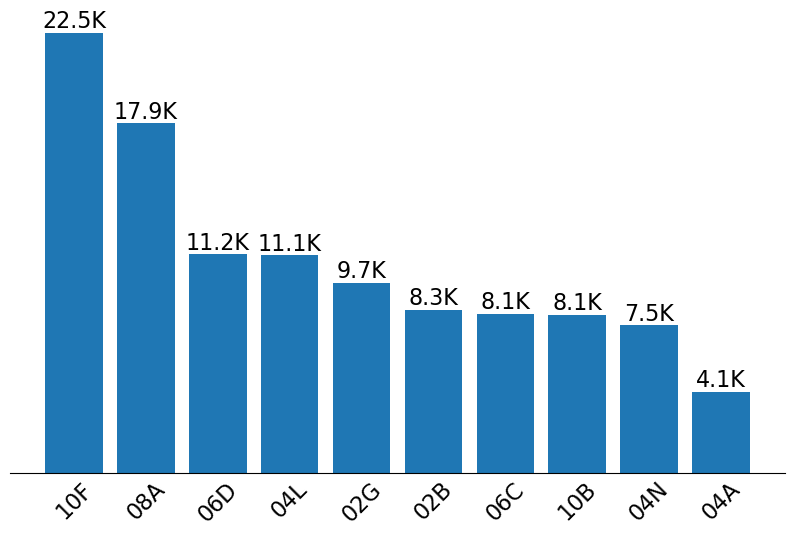

In [9]:
# Counting violations
violation_counts = inspection_df['violation_code'].value_counts().head(10)

# Creating the plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(violation_counts.index, violation_counts.values)

# Customizing the plot
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_visible(False)
ax.tick_params(axis='x', length=0)
plt.xticks(rotation=45, ha="center", fontsize=16)

# Adding values on top of bars
for bar in bars:
    height = bar.get_height()
    if height > 1000:
        text_label = f'{height / 1000:.1f}K'  # Format height in thousands with one decimal place
    else:
        text_label = str(int(round(height / 10) * 10))
    
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.1, text_label,
            ha='center', va='bottom', fontsize=16)

plt.show()

In [13]:
# Assuming you have a DataFrame called inspection_df with 'violation_code' and 'violation_description' columns

# Create a dictionary to map violation codes to descriptions
code_to_description = dict(zip(inspection_df['violation_code'], inspection_df['violation_description']))

# Print the dictionary
code_to_description


{'none': 'No violations were recorded',
 '09B': 'Thawing procedures improper.',
 '02B': 'Hot TCS food item not held at or above 140 °F.',
 '10J': 'Hand wash sign not posted',
 '04L': "Evidence of mice or live mice present in facility's food and/or non-food areas.",
 '09C': 'Food contact surface not properly maintained.',
 '04M': "Live roaches present in facility's food and/or non-food areas.",
 '10C': 'Lighting Inadequate',
 '06F': 'Wiping cloths not stored clean and dry, or in a sanitizing solution, between uses.',
 '05A': 'Sewage disposal system improper or unapproved.',
 '09E': 'Wash hands sign not posted near or above hand washing sink.',
 '10H': 'Proper sanitization not provided for utensil ware washing operation.',
 '04K': "Evidence of rats or live rats in establishment's food or non-food areas.",
 '04A': 'Food Protection Certificate (FPC) not held by manager or supervisor of food operations.',
 '08C': 'Pesticide not properly labeled or used by unlicensed individual.  Pesticide, 

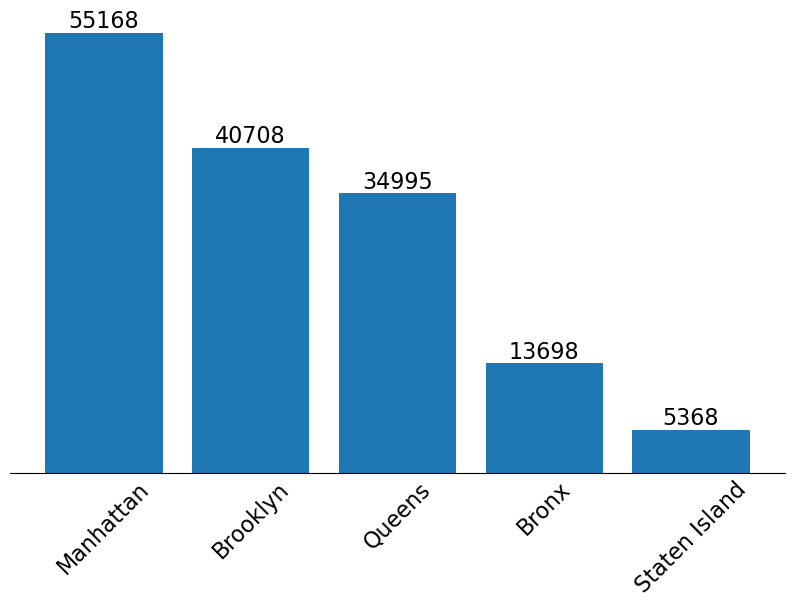

In [11]:
borough_counts = inspection_df['boro'].value_counts()

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(borough_counts.index, borough_counts.values)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_visible(False)
ax.tick_params(axis='x', length=0)
plt.xticks(rotation=45, ha="center", fontsize=16)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.1, str(int(height)),
            ha='center', va='bottom', fontsize=16)

plt.show()


In [11]:
# Calculate unique inspections by grouping by 'camis' and 'inspection_date'
unique_inspections = inspection_df.groupby(['camis', 'inspection_date']).size().reset_index(name='inspection_count')

# Get the distribution of boroughs for these unique inspections
borough_counts = unique_inspections['boro'].value_counts()

plt.figure(figsize=(10, 6))
ax = borough_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Restaurants by Borough for Unique Inspections')
plt.xticks(rotation=45)

# Display borough names on the bars
ax.set_xticklabels(borough_counts.index, rotation=45)

# Remove Y-axis
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', left=False, labelleft=False)

# Remove the square around the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove the horizontal X line
ax.spines['bottom'].set_visible(False)

# Remove X ticks
plt.xticks([])

# Remove X and Y labels
plt.xlabel('')
plt.ylabel('')

# Add values at the top of the bars
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

KeyError: 'boro'

In [12]:
unique_inspections.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46830 entries, 0 to 46829
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   camis             46830 non-null  int64 
 1   inspection_date   46830 non-null  object
 2   inspection_count  46830 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB
